In [ ]:
!unzip UCMerced_LandUse.zip

Archive:  UCMerced_LandUse.zip
   creating: UCMerced_LandUse/Images/
   creating: UCMerced_LandUse/Images/agricultural/
  inflating: UCMerced_LandUse/Images/agricultural/agricultural00.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural01.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural02.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural03.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural04.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural05.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural06.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural07.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural08.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural09.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural10.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural11.tif  
  inflating: UCMerced_LandUs

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(256, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root="UCMerced_LandUse/Images", transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

#custom CNN
class CustomCNN(nn.Module):
    def __init__(self, num_classes=21):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

custom_cnn = CustomCNN(num_classes=21).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_custom = optim.Adam(custom_cnn.parameters(), lr=0.001)

scheduler_custom = optim.lr_scheduler.StepLR(optimizer_custom, step_size=5, gamma=0.7)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")

train_model(custom_cnn, train_loader, val_loader, criterion, optimizer_custom, scheduler_custom, num_epochs=10)

Epoch 1/10, Loss: 3.0595, Accuracy: 0.0871
Epoch 2/10, Loss: 2.4592, Accuracy: 0.2415
Epoch 3/10, Loss: 2.0311, Accuracy: 0.3796
Epoch 4/10, Loss: 1.6620, Accuracy: 0.4850
Epoch 5/10, Loss: 1.5551, Accuracy: 0.5122
Epoch 6/10, Loss: 1.3219, Accuracy: 0.5823
Epoch 7/10, Loss: 1.1877, Accuracy: 0.6122
Epoch 8/10, Loss: 1.1278, Accuracy: 0.6395
Epoch 9/10, Loss: 0.9962, Accuracy: 0.6844
Epoch 10/10, Loss: 0.9271, Accuracy: 0.6946


In [ ]:
# Load pretrained ResNet18 model
resnet = models.resnet18(pretrained=True)

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 21)

for param in resnet.parameters():
    param.requires_grad = False

for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = resnet.to(device)

for name, param in resnet.named_parameters():
    print(f'{name}: {param.requires_grad}')

optimizer_resnet = optim.Adam(resnet.fc.parameters(), lr=0.001)

scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=5, gamma=0.7)

train_model(resnet, train_loader, val_loader, criterion, optimizer_resnet, scheduler_resnet, num_epochs=10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


conv1.weight: False
bn1.weight: False
bn1.bias: False
layer1.0.conv1.weight: False
layer1.0.bn1.weight: False
layer1.0.bn1.bias: False
layer1.0.conv2.weight: False
layer1.0.bn2.weight: False
layer1.0.bn2.bias: False
layer1.1.conv1.weight: False
layer1.1.bn1.weight: False
layer1.1.bn1.bias: False
layer1.1.conv2.weight: False
layer1.1.bn2.weight: False
layer1.1.bn2.bias: False
layer2.0.conv1.weight: False
layer2.0.bn1.weight: False
layer2.0.bn1.bias: False
layer2.0.conv2.weight: False
layer2.0.bn2.weight: False
layer2.0.bn2.bias: False
layer2.0.downsample.0.weight: False
layer2.0.downsample.1.weight: False
layer2.0.downsample.1.bias: False
layer2.1.conv1.weight: False
layer2.1.bn1.weight: False
layer2.1.bn1.bias: False
layer2.1.conv2.weight: False
layer2.1.bn2.weight: False
layer2.1.bn2.bias: False
layer3.0.conv1.weight: False
layer3.0.bn1.weight: False
layer3.0.bn1.bias: False
layer3.0.conv2.weight: False
layer3.0.bn2.weight: False
layer3.0.bn2.bias: False
layer3.0.downsample.0.weight: 

Test Accuracy: 0.4984
Test Accuracy: 0.4984, Precision: 0.5585, Recall: 0.4984, F1-score: 0.4931


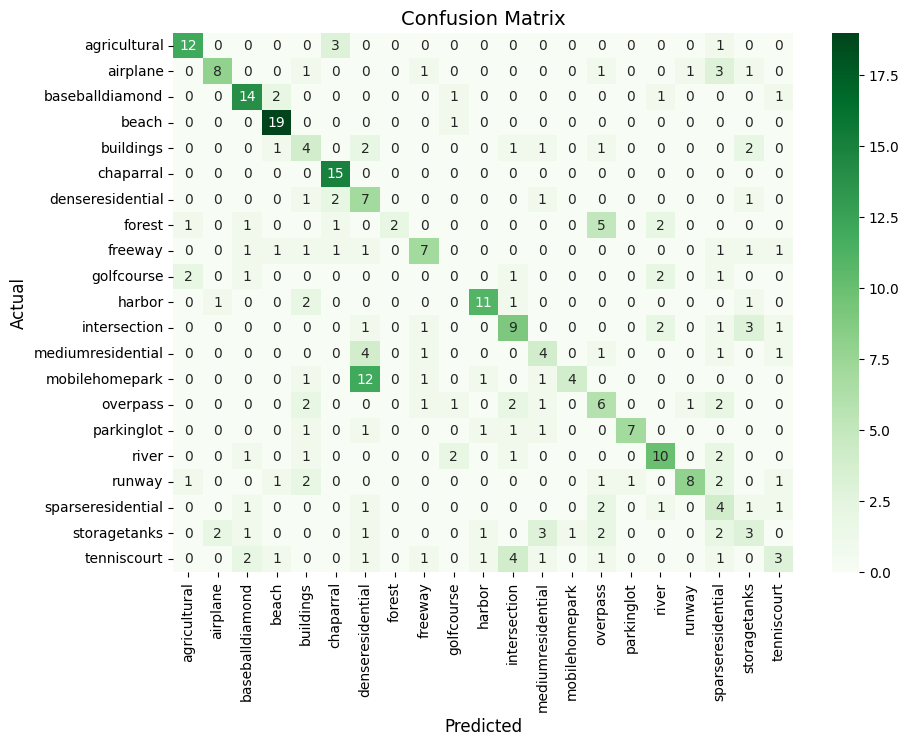

Test Accuracy: 0.9079
Test Accuracy: 0.9079, Precision: 0.9205, Recall: 0.9079, F1-score: 0.9105


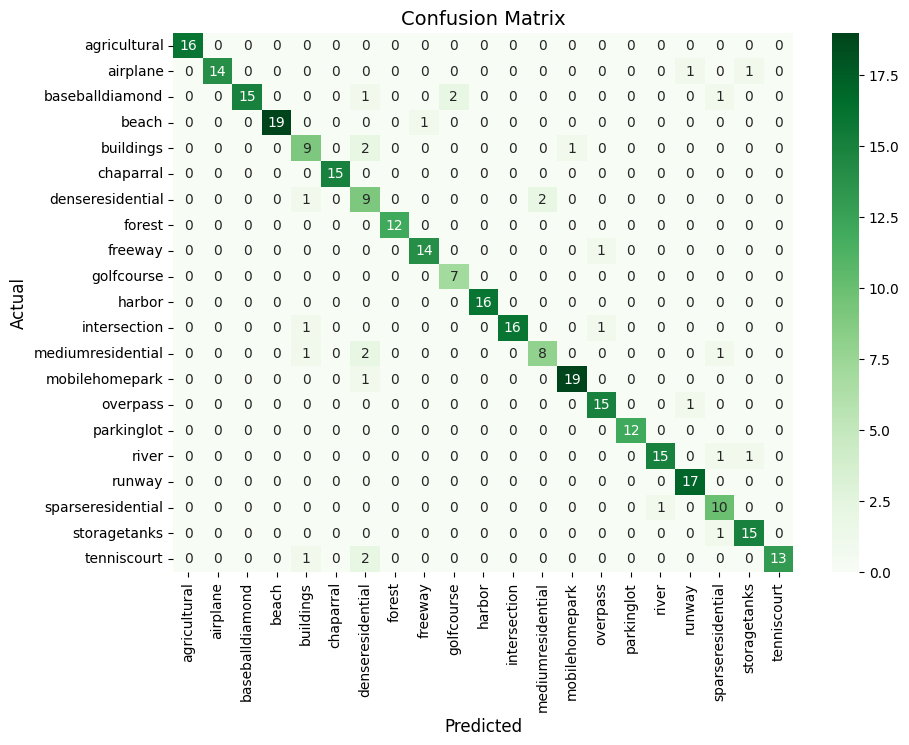

In [ ]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"Test Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    return y_true, y_pred

# Confusion matrix plotting
def plot_confusion_matrix(model, test_loader, class_names):
    y_true, y_pred = evaluate_model(model, test_loader)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.show()

# Get class names and plot confusion matrices
class_names = dataset.classes
plot_confusion_matrix(custom_cnn, test_loader, class_names)
plot_confusion_matrix(resnet, test_loader, class_names)